In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn')

# Predicting the Truckee River Flow

![](https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/fall-on-the-truckee-river-vance-fox.jpg)


The Truckee River relies on snow that falls in the Sierra Nevada during the winter months, and natural run-off combined with releases of water from Lake Tahoe and other reservoirs during the summer months to maintain flows that support water consumption needs.

![image.png](https://tmwa.com/images/riversystem_map.gif)

## Data

Assumptions
conservation of mass
    - input rivers should add up to river output (pending no small streams, snowmelt, rain)
precipitation can either add to or not effect river flow. 
    - if temperatue is low, rain is snow
    - Large rain storms lead to snow melt, feeding the river

In [2]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n - 1:] /= n
    return ret

df = pd.read_pickle('./data/clean_data.pkl')

In [3]:
df.head()

,time,truckee,tahoe,donner,boca,rain,snow,temp
0,2017-01-01,12.14928,0.597552,2.588448,0.770304,2.5,94.0,-1.8
1,2017-01-02,11.61120,0.230525,2.319408,0.775968,15.2,109.2,-5.0
2,2017-01-03,11.04480,0.045312,2.225952,0.775968,35.6,144.8,-1.0
3,2017-01-04,14.64144,0.300192,2.293920,0.265358,66.0,221.0,1.0
4,2017-01-05,16.45392,0.348336,2.319408,0.003398,7.6,228.6,-4.0


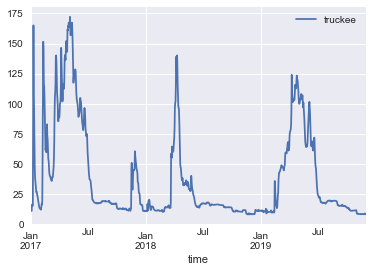

In [4]:
df.plot('time', 'truckee')

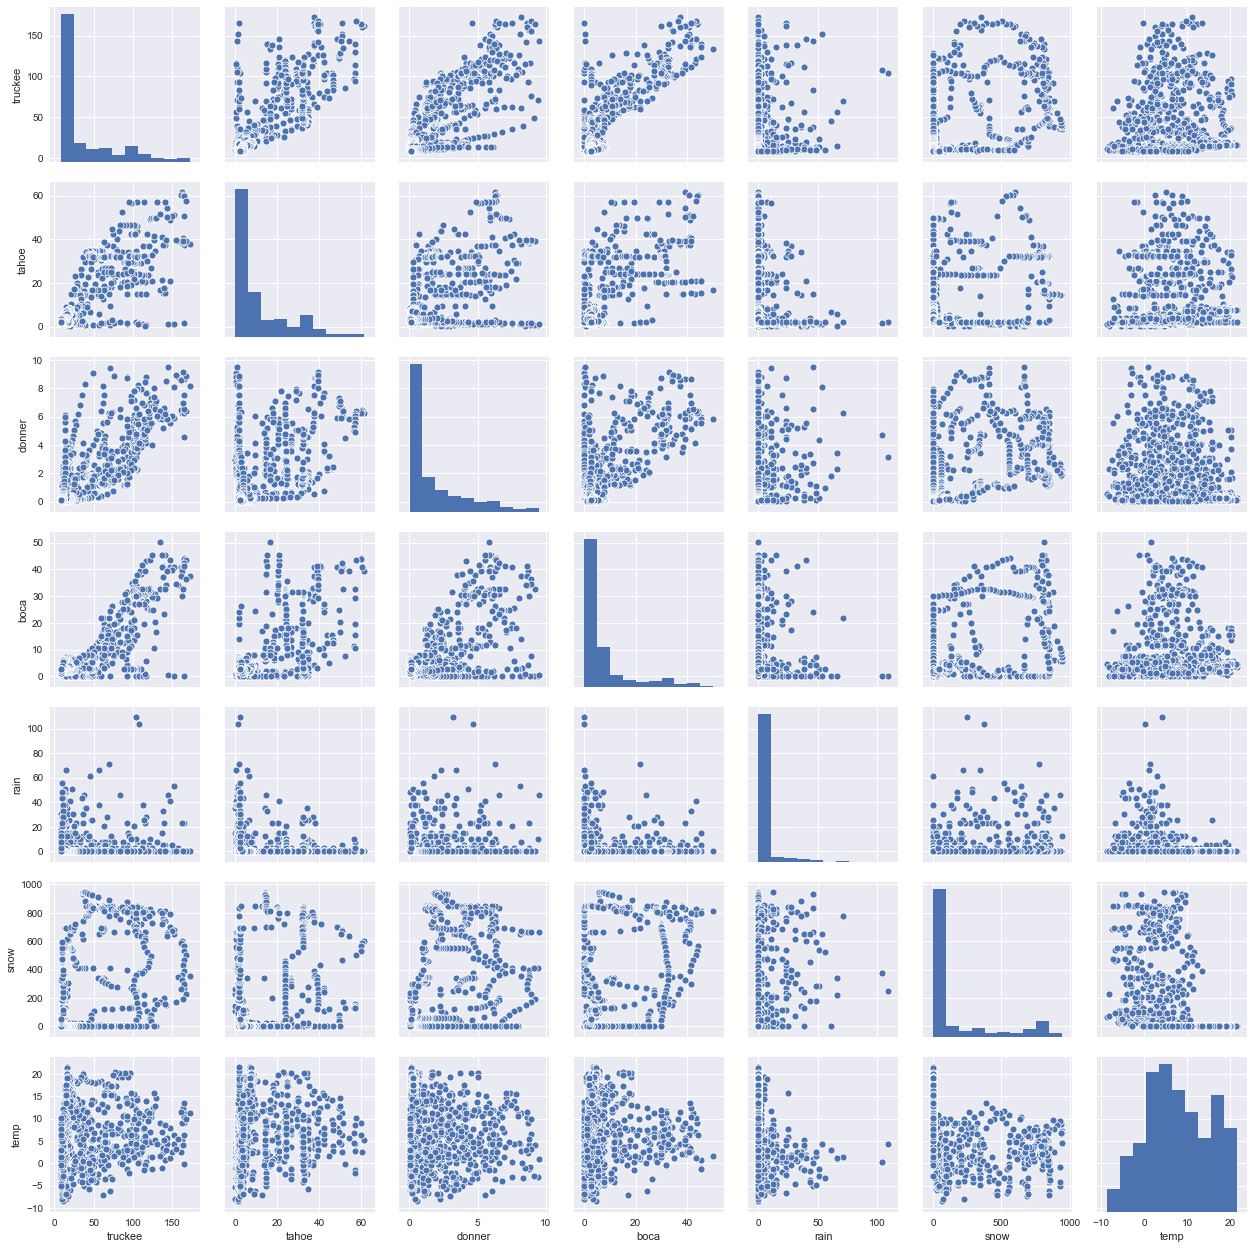

In [5]:
sns.pairplot(df)

Text(0, 0.5, 'Truckee Flow')

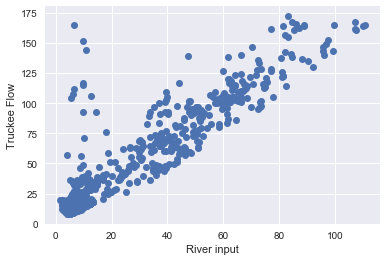

In [6]:
river_input = df.tahoe + df.donner + df.boca
plt.plot(river_input, df.truckee, 'o')
plt.xlabel("River input")
plt.ylabel("Truckee Flow")

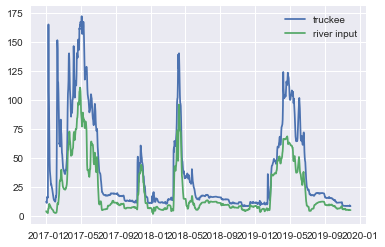

In [7]:
plt.plot(df.time, df.truckee, label='truckee')
plt.plot(df.time, river_input, label='river input')
plt.legend()

In [8]:
dsnow = np.zeros_like(df.snow) 
dsnow[1:] = moving_average(np.diff(df.snow), n=3)
avg_rain = moving_average(df.rain.values, n=3)
avg_temp = moving_average(df.temp.values, n=3)

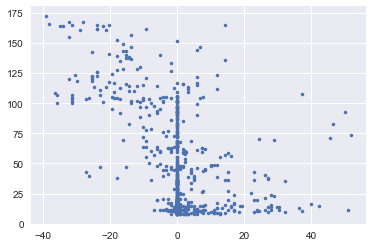

In [9]:
plt.plot(dsnow, df.truckee, '.')

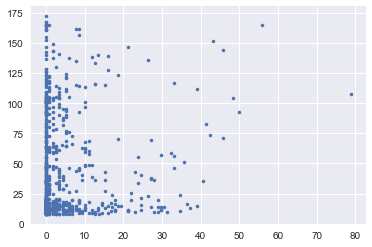

In [10]:
plt.plot(avg_rain, df.truckee, '.')

## Fit the data

In [11]:
X = np.c_[river_input.values, dsnow, avg_rain]
reg = LinearRegression().fit(X, df.truckee.values)

In [12]:
p = reg.predict(X)

In [13]:
print("y = {:.2f}*river_input + {:.4f}*delta_snow_pack + {:.4f}*avg_rain + {:.4f}".format(*reg.coef_, reg.intercept_))

y = 1.41*river_input + -0.8322*delta_snow_pack + 1.4430*avg_rain + 3.5657


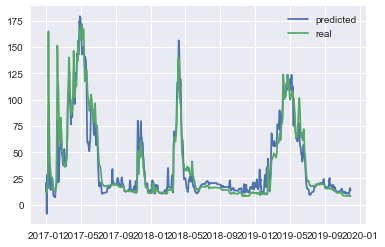

In [14]:
plt.plot(df.time, p, label='predicted')
plt.plot(df.time, df.truckee, label='real')
plt.legend()

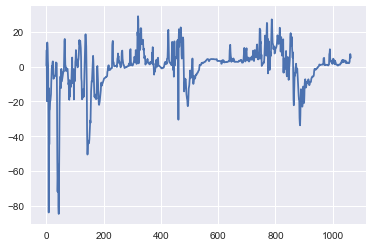

In [15]:
plt.plot(p-df.truckee)

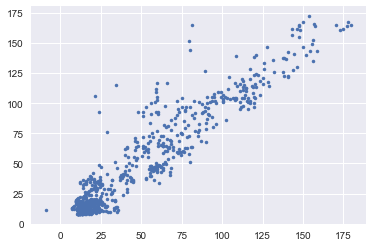

In [16]:
plt.plot(p, df.truckee, '.')

# Bayesian Linear Regression

In [17]:
from jax import random
import jax.numpy as np

import numpy as onp
import numpyro
import numpyro.diagnostics as diag
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(3)
numpyro.enable_validation()

num_warmup, num_samples = 1000, 5000
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [18]:
def dic(model_fn, samples, **kwargs):
    pi_theta = numpyro.infer.log_likelihood(model_fn, samples, **kwargs)['y'].sum(axis=1)
    D_bar = -2 * pi_theta.mean(axis=0)
    theta_star = {k: v.mean(axis=0, keepdims=True) for k, v in samples.items()}
    pi_theta_star = numpyro.infer.log_likelihood(model_fn, theta_star, **kwargs)['y'].sum()
    D_theta_star = -2 * pi_theta_star
    print('expected deviance:', D_bar)
    print('effective number of parameters:', D_bar - D_theta_star)
    print('DIC:', D_bar - D_theta_star + D_bar)

In [19]:
def model_fn(X, T):
    mu = numpyro.sample('mu', dist.Normal(np.zeros(4), 1e6))
    std = numpyro.sample('std', dist.Exponential(1))
    y = X @ mu
    numpyro.sample('y', dist.Normal(loc=y, scale=std), obs=T)

In [20]:
X = np.vstack([river_input.values, dsnow, avg_rain, np.ones_like(dsnow)]).T

kernel = NUTS(model_fn)
model = MCMC(kernel, num_warmup, num_samples, num_chains=3)
model.run(rng_key, collect_warmup=False, X=X, T=df.truckee.values)

In [21]:
model.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      1.41      0.02      1.41      1.38      1.45   7495.98      1.00
     mu[1]     -0.83      0.06     -0.83     -0.94     -0.73   7310.36      1.00
     mu[2]      1.44      0.07      1.44      1.33      1.55   8250.53      1.00
     mu[3]      3.57      0.54      3.57      2.66      4.44  10362.98      1.00
       std     11.80      0.25     11.80     11.38     12.20  11801.67      1.00

Number of divergences: 0


In [22]:
samples = model.get_samples()
mu = samples['mu']

In [23]:
dic(model_fn, samples, X=X, T=df.truckee.values)

expected deviance: 8281.153
effective number of parameters: 5.0029297
DIC: 8286.156


In [24]:
p = X @ mu.T
p_mean = p.mean(axis=1)
p_std = p.std(axis=1)

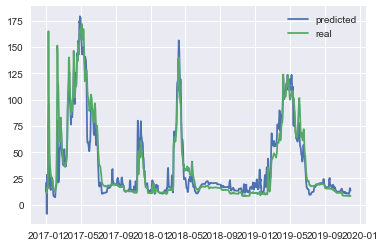

In [25]:
plt.plot(df.time, p.mean(axis=1), label='predicted')
plt.plot(df.time, df.truckee, label='real')
plt.legend()

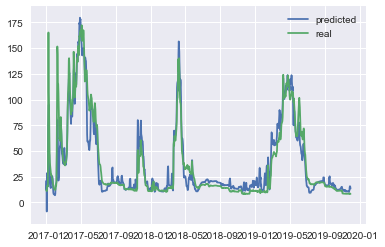

In [26]:
plt.plot(df.time, p_mean, label='predicted')
plt.fill_between(df.time, p_mean - p_std, p_mean + p_std, alpha=.9)
plt.plot(df.time, df.truckee, label='real')
plt.legend()

In [27]:
std = samples['std']
obs = onp.random.normal(p, std)

In [28]:
obs_mean = obs.mean(axis=1)
obs_std = obs.std(axis=1)

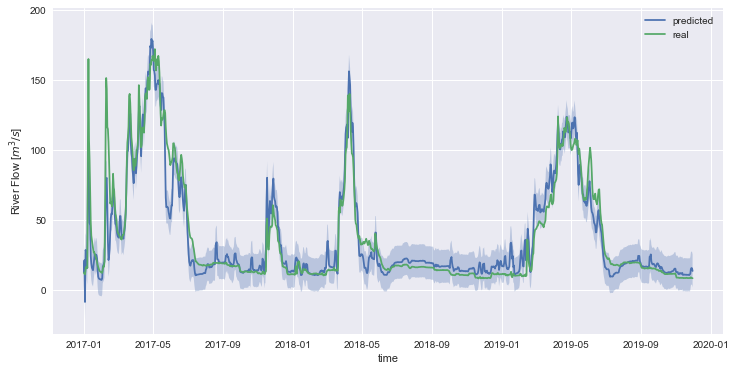

In [29]:
plt.figure(figsize=(12,6))
plt.plot(df.time, obs_mean, label='predicted')
plt.fill_between(df.time, obs_mean - obs_std, obs_mean + obs_std, alpha=.3)
plt.plot(df.time, df.truckee, label='real')
plt.xlabel('time')
plt.ylabel('River Flow [$m^3/s$]')
plt.legend()

# Alternative model

In [30]:
def model_fn(X, T):
    mu = numpyro.sample('mu', dist.Normal(np.zeros(6), 1e6))
    std = numpyro.sample('std', dist.Exponential(1))
    y = X @ mu
    numpyro.sample('y', dist.Normal(loc=y, scale=std), obs=T)
    
X = np.vstack([df.boca, df.tahoe, df.donner, dsnow, avg_rain, np.ones_like(dsnow)]).T

kernel = NUTS(model_fn)
model = MCMC(kernel, num_warmup, num_samples, num_chains=3)
model.run(rng_key, collect_warmup=False, X=X, T=df.truckee.values)

In [31]:
model.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      1.21      0.05      1.21      1.13      1.29  14248.90      1.00
     mu[1]      1.17      0.03      1.17      1.12      1.22  16062.51      1.00
     mu[2]      5.05      0.21      5.05      4.70      5.37  14785.20      1.00
     mu[3]     -0.66      0.06     -0.66     -0.76     -0.57  11687.75      1.00
     mu[4]      1.02      0.06      1.02      0.92      1.12  10728.03      1.00
     mu[5]      2.92      0.47      2.92      2.14      3.68  16223.93      1.00
       std     10.36      0.22     10.35     10.00     10.73  16924.01      1.00

Number of divergences: 0


In [32]:
samples = model.get_samples()
mu = samples['mu']
p = X @ mu.T
p_mean = p.mean(axis=1)
p_std = p.std(axis=1)

std = samples['std']
obs = onp.random.normal(p, std)
obs_mean = obs.mean(axis=1)
obs_std = obs.std(axis=1)

In [33]:
dic(model_fn, samples, X=X, T=df.truckee.values)

expected deviance: 8002.5474
effective number of parameters: 6.9140625
DIC: 8009.4614


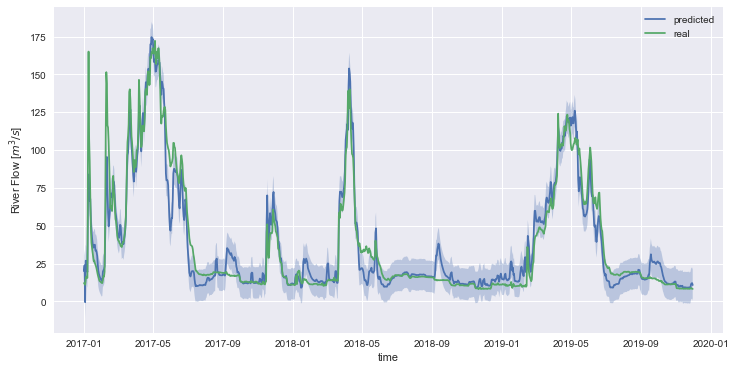

In [34]:
plt.figure(figsize=(12,6))
plt.plot(df.time, obs_mean, label='predicted')
plt.fill_between(df.time, obs_mean - obs_std, obs_mean + obs_std, alpha=.3)
plt.plot(df.time, df.truckee, label='real')
plt.xlabel('time')
plt.ylabel('River Flow [$m^3/s$]')
plt.legend()

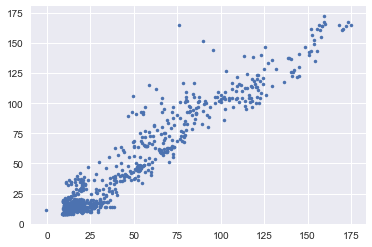

In [35]:
plt.plot(p_mean, df.truckee, '.')

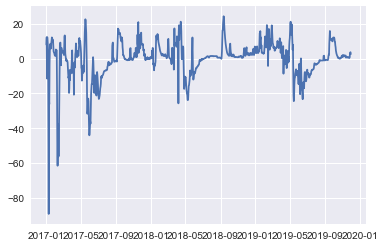

In [36]:
plt.plot(df.time, p_mean - df.truckee.values)

In [43]:
onp.where((p_mean - df.truckee.values) < -80)

(array([8]),)

In [44]:
df.time[8]

Timestamp('2017-01-09 00:00:00')

In [45]:
D = np.vstack([df.boca[8], df.tahoe[8], df.donner[8], dsnow[8], avg_rain[8], 1]).T
pd = X @ mu.T

In [48]:
(pd > 150).mean()

DeviceArray(0.02199204, dtype=float32)